# Comparing data I/O

This notebook compares read and write speeds for different file formats used within the HiP-CT project.

Currently all tests are run locally on a MacBook Air M2 (2022).

In [3]:
from pathlib import Path
from collections import defaultdict
import tempfile
import time

import glymur
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import pandas as pd

In [4]:
dtype = np.uint16

## Function to time JPEG2000 files

In [5]:
def time_jp2(size, cratio=10) -> tuple[float, float]:
    """
    Time saving a JPEG2000 image. Includes time to create the file.
    """
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)
        data = np.random.randint(low=0, high=2**16, size=(size, size), dtype=dtype)

        start = time.time()
        jp2 = glymur.Jp2k(temp_path / f"{size}.jp2", cratios=[cratio])
        jp2[:] = data
        write_time = time.time() - start

        start = time.time()
        jp2 = glymur.Jp2k(temp_path / f"{size}.jp2")
        data = jp2[:]
        read_time = time.time() - start

        return write_time, read_time

## Function to time TIFF files

In [6]:
def time_tiff(size) -> float:
    """
    Time saving a TIFF image. Includes time to create the file.
    """
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)
        data = np.random.randint(low=0, high=2**16, size=(size, size), dtype=dtype)

        start = time.time()
        tifffile.imwrite(temp_path / f"{size}.tif", data)
        write_time = time.time() - start

        start = time.time()
        tifffile.imread(temp_path / f"{size}.tif")
        read_time = time.time() - start

        return write_time, read_time

## Compare JPEG2000/TIFF

In [7]:
results = {}
for fmt, time_func in zip(['JPEG2000', "TIFF"], [time_jp2, time_tiff]):
    print(fmt)
    npixels = []
    write_times = []
    read_times = []

    for i in range(6, 13):
        size = 2**i
        npixels.append(size**2)
        write_time, read_time = time_func(size)
        write_times.append(write_time)
        read_times.append(read_time)

    df = pd.DataFrame({"npix": npixels, 'write_time': write_times, 'read_time': read_times})
    results[fmt] = df

JPEG2000
TIFF


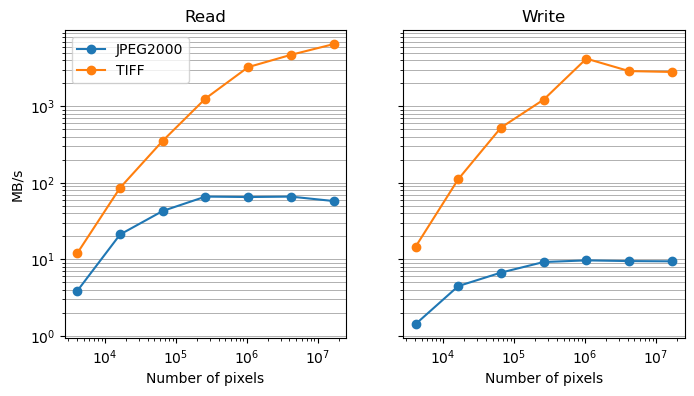

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for fmt in ['JPEG2000', "TIFF"]:
    df = results[fmt]

    for ax, res in zip(axs, ['read', 'write']):
        write_speed = df['npix'] * 2 / 1e6 / df[f'{res}_time']
        ax.plot(df['npix'], write_speed, marker='o', label=fmt)
        ax.set_title(res.capitalize())


for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of pixels")
    ax.yaxis.grid(which="both", linewidth=0.7, alpha=1)

axs[0].set_ylabel("MB/s")
axs[0].legend()